In [1]:
import spikeinterface.full as si # load_extractor, plot_traces
from pathlib import Path
import numcodecs
import spikeinterface.preprocessing as spre

# Write here the location of the test dataset that you downloaded
data_path = Path("/Users/vigji/Desktop/test-compression/test-data")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [17]:
# load_extractor is a function that can be used to load data already imported in a 
# spikeinterface-compatible structure:
test_data = si.load_extractor(data_path)

# This compression has been optimized to get to high compression ratios while taking quite some time to run.
# This is because we expect to compress/decompress the data only once a spike sorting is final, and we do not really care 
# if this takes a few minutes. Expected time is approx. 5X real time (duration of the recording) for 30kHz sampling rate on SSD.

# To learn a bit more about other compression options, check this out: https://iopscience.iop.org/article/10.1088/1741-2552/acf5a4#jneacf5a4s5

# Ensure least significant bit is 1
comp_data_lsb_corr = spre.correct_lsb(test_data, verbose=True)


cname = "lzma"
level = 1  # higher ratios makes it much longer without much gain in CR

compressed_path = data_path.parent / f"test_dataset_compressed_{cname}_lsb_{level}"

compressor = numcodecs.registry.codec_registry[cname](preset=level)

# Save using compression in zarr format:
comp_data_lsb_corr.save(folder=compressed_path,
                    format="zarr",
                    compressor=compressor,
                    channel_chunk_size=-1,
                    chunk_duration=10.,
                    n_jobs=5,
                    filters=[]  # prefiltering does not help with lzma
                )

write_zarr_recording with n_jobs = 5 and chunk_size = 300000


write_zarr_recording:   0%|          | 0/10 [00:00<?, ?it/s]

ZarrRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 3,000,000 samples 
                        100.00s (1.67 minutes) - int16 dtype - 2.15 GiB

In [18]:
# Load the compressed data:
comp_data = si.load_extractor(compressed_path.parent / (compressed_path.name + ".zarr"))

In [19]:
# We save data in native format (no compression) to compare with the compressed data:
back_conv_path = data_path.parent / "reconstructed"
comp_data.save(folder=back_conv_path, compressor=None, n_jobs=5)

write_binary_recording with n_jobs = 5 and chunk_size = 30000


write_binary_recording:   0%|          | 0/100 [00:00<?, ?it/s]

BinaryFolderRecording: 384 channels - 30.0kHz - 1 segments - 3,000,000 samples 
                       100.00s (1.67 minutes) - int16 dtype - 2.15 GiB

In [20]:
reconstructed_data = si.load_extractor(back_conv_path)

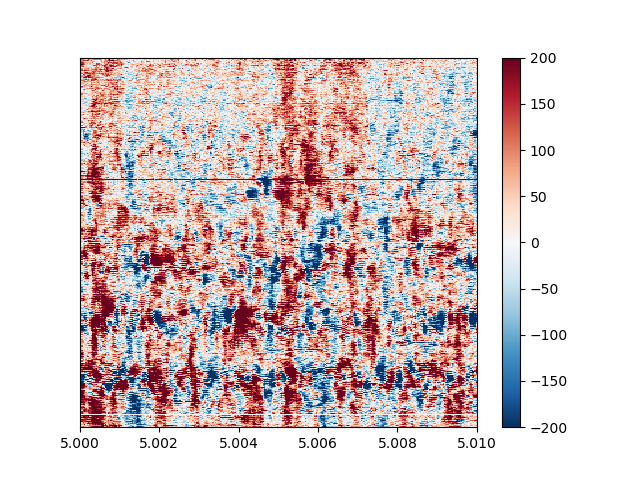

In [21]:
%matplotlib widget
si.plot_traces(test_data, backend="matplotlib", # "ipywidgets", 
               mode='map', time_range=(5, 5.01))

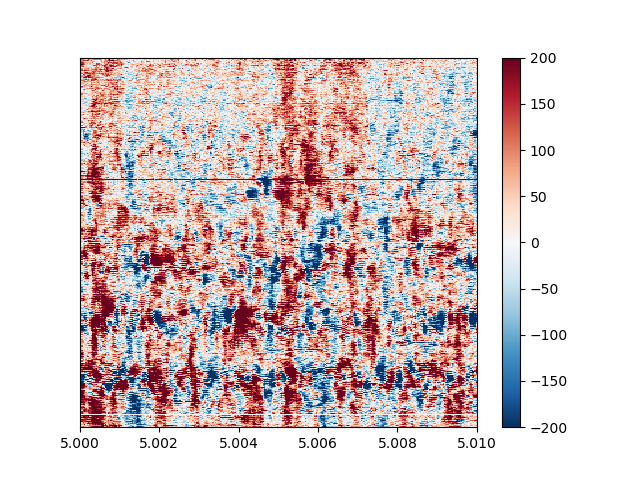

In [22]:
%matplotlib widget
si.plot_traces(reconstructed_data, backend="matplotlib", # "ipywidgets", 
               mode='map', time_range=(5, 5.01))